# Global Forecast System Proof of Concept

This notebook is a proof of concept for working with the Global Forecast System (GFS). The GFS is a weather forecast model that publishes its data publicly to AWS S3. This notebook demonstrates how to access this data and plot it using Python.

In [10]:
import os
from logging import debug, info, warning, error, critical

import logging

logging.basicConfig(
    level=logging.INFO,
    stream=os.sys.stdout,
)

## Data Download

The first step is to download the data. The data is stored in the `noaa-gfs-bdp-pds` bucket on AWS S3. The data is organized by year, month, day, and hour.

- Available GFS Parameter Sets: https://www.nco.ncep.noaa.gov/pmb/products/gfs/
- AWS S3 Bucket: https://noaa-gfs-bdp-pds.s3.amazonaws.com/index.html

The data is stored in GRIB2 format.

In [11]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config

import time
from datetime import timedelta
from concurrent.futures import ThreadPoolExecutor

from typing import List, Literal


def downloadGfsForecast(
    saveDir: str,
    forecastHours: int = 24,
    gridResolution: Literal["1p00", "0p50", "0p25"] = "1p00",
    tNow: time.struct_time = time.gmtime(),
) -> List[str]:
    GFS_BUCKET_NAME = "noaa-gfs-bdp-pds"
    GFS_BUCKET_REGION = "us-east-1"

    s3 = boto3.resource(
        "s3",
        region_name=GFS_BUCKET_REGION,
        config=Config(
            signature_version=UNSIGNED,  # Unsigned as the bucket is public
            max_pool_connections=100,  # Else get a warning
        ),
    )

    yyymmdd = time.strftime("%Y%m%d")
    lastHourlyQuarter = int(time.strftime("%H", tNow)) // 6 * 6
    hh = f"{lastHourlyQuarter:02d}"

    bucketSubdir = f"gfs.{yyymmdd}/{hh}/atmos"
    fileNames = [
        f"gfs.t{hh}z.pgrb2.{gridResolution}.f{i:03d}"  # Assume pgrb2 as common parameter set
        for i in range(0, forecastHours + 1)
    ]

    if gridResolution == "0p50" or gridResolution == "1p00":
        debug(f"{gridResolution} implies 3-hourly forecast intervals")
        fileNames = fileNames[::3]

    os.makedirs(saveDir, exist_ok=True)

    existingFiles = os.listdir(saveDir)

    filesToDownload = [file for file in fileNames if file not in existingFiles]

    def downloadFromS3(filename, saveDir=saveDir):
        """
        Download process for a single GFS file from AWS S3
        """
        info(f"Downloading {filename}")

        try:
            s3.Bucket(GFS_BUCKET_NAME).download_file(
                f"{bucketSubdir}/{filename}",
                f"{saveDir}/{filename}",
            )
        except Exception as e:
            error(f"Error downloading {filename}: {e}")

    with ThreadPoolExecutor() as executor:
        executor.map(downloadFromS3, filesToDownload)

    existingFiles = os.listdir(saveDir)  # Update list of existing files
    for file in existingFiles:
        if file not in fileNames:
            warning(
                f"File {file} in {saveDir} is not part of the current forecast. Deleting."
            )
            os.remove(f"{saveDir}/{file}")

    return os.listdir(saveDir)


dataSaveDir = f"Data/{time.strftime('%Y%m%d', time.gmtime())}"
forecastHours = 24 * 2
forecastFiles = downloadGfsForecast(
    saveDir=dataSaveDir,
    gridResolution="0p50",
    forecastHours=forecastHours,
    # Set time to be the current GMT time minus 6 hours to ensure that the latest forecast is downloaded
    tNow=time.gmtime(time.time() - 6 * 3600),
)

INFO:root:Downloading gfs.t06z.pgrb2.0p50.f000
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f003
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f006
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f009
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f012
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f015
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f018
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f021
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f024
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f027
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f030
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f033
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f036
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f039
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f042
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f045
INFO:root:Downloading gfs.t06z.pgrb2.0p50.f048


## Data Exploration

The `cfgrib` library is used to read the GRIB2 files. 

Example data is explored to understand the structure of the data.

In [ ]:
import xarray as xr

ds = xr.open_dataset(
    os.path.join(dataSaveDir, forecastFiles[0]),
    engine="cfgrib",
    filter_by_keys={
        "typeOfLevel": "surface",
        "stepType": "instant",
    },
)

IndexError: list index out of range

In [ ]:
for v in ds:
    print(f"{v}\t{ds[v].attrs['long_name']}, {ds[v].attrs['units']}")

vis	Visibility, m
gust	Wind speed (gust), m s**-1
hindex	Haines Index, Numeric
sp	Surface pressure, Pa
orog	Orography, m
t	Temperature, K
cnwat	Plant canopy surface water, kg m**-2
sdwe	Water equivalent of accumulated snow depth (deprecated), kg m**-2
sde	Snow depth, m
unknown	unknown, unknown
sithick	Sea ice thickness, m
cpofp	Percent frozen precipitation, %
cprat	Convective precipitation rate, kg m**-2 s**-1
prate	Precipitation rate, kg m**-2 s**-1
csnow	Categorical snow, (Code table 4.222)
cicep	Categorical ice pellets, (Code table 4.222)
cfrzr	Categorical freezing rain, (Code table 4.222)
crain	Categorical rain, (Code table 4.222)
fsr	Forecast surface roughness, m
fricv	Frictional velocity, m s**-1
veg	Vegetation, %
slt	Soil type, (Code table 4.213)
wilt	Wilting Point, Fraction
fldcp	Field Capacity, Fraction
SUNSD	Sunshine Duration, s
lftx	Surface lifted index, K
cape	Convective available potential energy, J kg**-1
cin	Convective inhibition, J kg**-1
lftx4	Best (4-layer) lifted ind

In [ ]:
print(ds)

<xarray.Dataset> Size: 133MB
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  datetime64[ns] 8B ...
Data variables: (12/32)
    vis         (latitude, longitude) float32 4MB ...
    gust        (latitude, longitude) float32 4MB ...
    hindex      (latitude, longitude) float32 4MB ...
    sp          (latitude, longitude) float32 4MB ...
    orog        (latitude, longitude) float32 4MB ...
    t           (latitude, longitude) float32 4MB ...
    ...          ...
    cape        (latitude, longitude) float32 4MB ...
    cin         (latitude, longitude) float32 4MB ...
    lftx4       (latitude, longitude) float32 4MB ...
    lsm         (latitude, longitude) float32 4MB ...
    siconc      (la

In [ ]:
temperature = ds.get("t")

print(temperature)

<xarray.DataArray 't' (latitude: 721, longitude: 1440)> Size: 4MB
[1038240 values with dtype=float32]
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  datetime64[ns] 8B ...
Attributes: (12/30)
    GRIB_paramId:                             130
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Temperature
    GRIB_shortName:                           t
    GRIB_units:                               K
    long_name:                                T

## Plotting

`matplotlib` can plot the data with the appropriate projections.

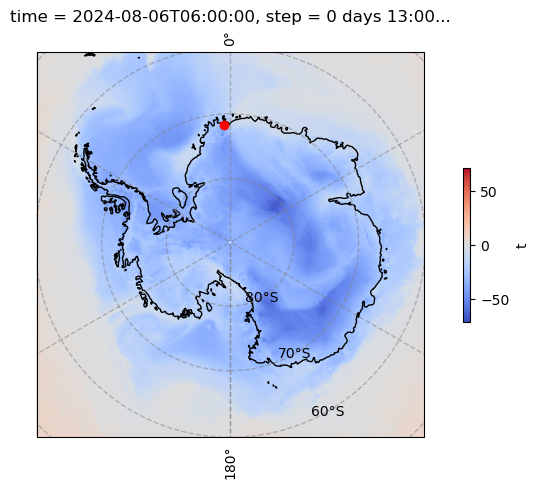

In [ ]:
latitudes = temperature.latitude.values
longitudes = temperature.longitude.values

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

t_celsius = temperature - 273.15
t_celsius.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    cbar_kwargs={"shrink": 0.4},
)

ax.coastlines()
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color="gray",
    alpha=0.5,
    linestyle="--",
)

SANAE_IV = (-71.673611, -2.828611)
ax.plot(
    SANAE_IV[1],
    SANAE_IV[0],
    "ro",
    transform=ccrs.PlateCarree(),
    label="SANAE IV",
)

## Local Forecast

The GFS data local to a specific location can be extracted and plotted.

In [ ]:
# Extract the temperature at SANAE IV and save as timeseries for all forecast files

import pandas as pd

temperatureForecast = []

for file in forecastFiles:
    ds = xr.open_dataset(
        os.path.join(dataSaveDir, file),
        engine="cfgrib",
        filter_by_keys={
            "typeOfLevel": "surface",
            "stepType": "instant",
        },
    )

    temperature = ds.get("t")
    temperatureSanae = temperature.sel(
        latitude=SANAE_IV[0], longitude=SANAE_IV[1], method="nearest"
    )
    timeSanae = ds.valid_time.values

    temperatureForecast.append((timeSanae, temperatureSanae.values - 273.15))

temperatureForecast.sort(key=lambda x: x[0])
temperatureForecast = pd.DataFrame(temperatureForecast, columns=["Time", "Temperature"])

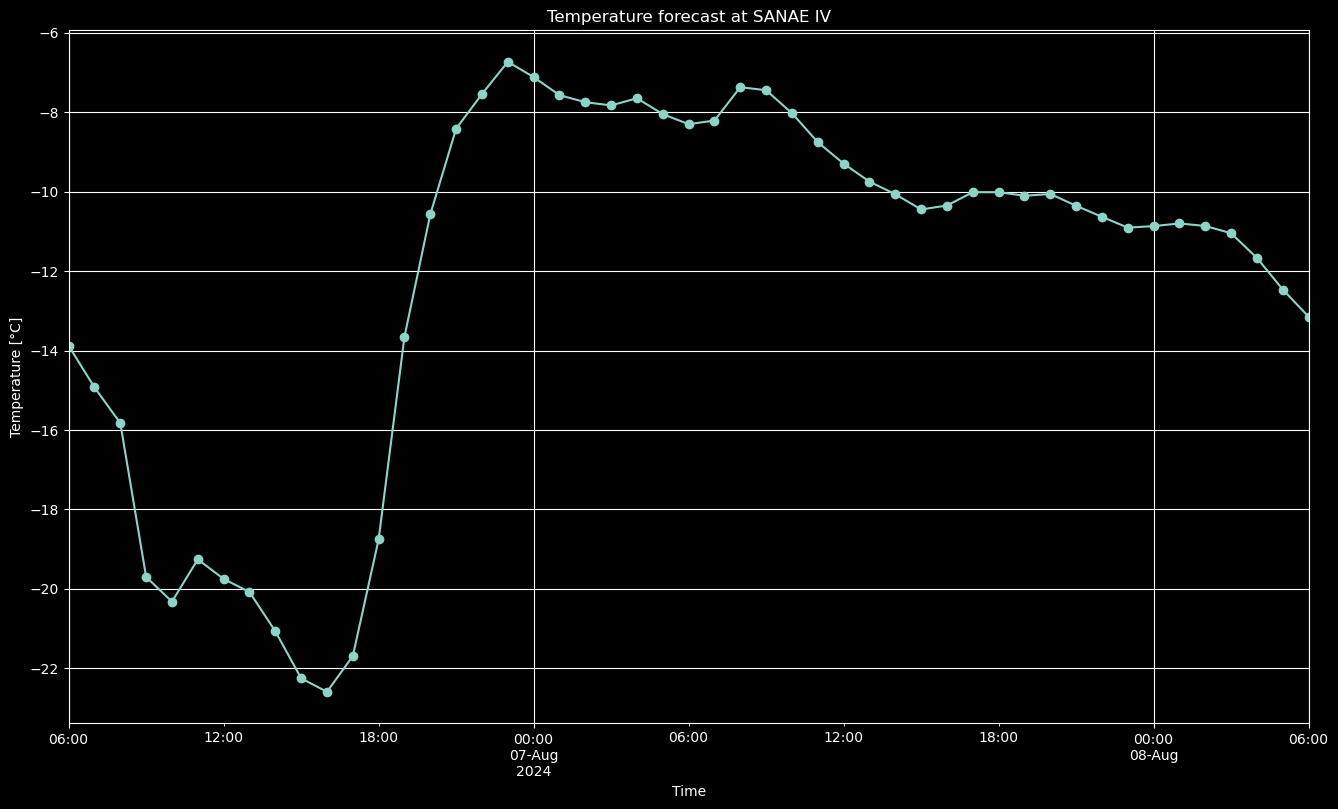

In [ ]:
with plt.style.context("dark_background"):
    temperatureForecast.plot(
        x="Time",
        y="Temperature",
        marker="o",
        title="Temperature forecast at SANAE IV",
        ylabel="Temperature [°C]",
        xlim=(
            temperatureForecast.Time.min(),
            temperatureForecast.Time.min() + pd.Timedelta(hours=forecastHours),
        ),
        figsize=(16, 9),
        grid=True,
        legend=False,
    )